### 필요한 라이브러리 다운로드 및 임포트

In [ ]:
#%pip install -U git+https://github.com/albumentations-team/albumentations
#%pip install opencv-python
#%pip install seaborn
#%pip install pandas
#%pip install matplotlib
#%pip install tensorflow
%pip install opendatasets

In [1]:
import tensorflow
print("Current tensorflow version == {}".format(tensorflow.__version__))

Current tensorflow version == 2.7.0


In [2]:
import os
import random
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns
import cv2
from warnings import filterwarnings
filterwarnings("ignore")

In [3]:
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import save_img
import albumentations as A
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import Sequence

In [34]:
import time  
import datetime #https://bio-info.tistory.com/143
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import load_model, Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import VGG16, ResNet50, Xception, InceptionV3
from tensorflow.keras.applications import EfficientNetB0 
from tensorflow.keras import Input
from tensorflow.keras import regularizers

In [5]:
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve

### 데이터세트 로딩 및 살펴보기 Load Dataset and Exploration 

In [7]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:Your Kaggle Key:Downloading chest-xray-pneumonia.zip to .\chest-xray-pneumonia


100%|██████████| 2.29G/2.29G [01:53<00:00, 21.7MB/s]


In [16]:
# 이미지 디렉토리 검색
img_dir = 'C:/Users/sunny/Documents/MASTER/DeepLearning/x-ray-image/chest-xray-pneumonia/chest_xray'
print(os.listdir(img_dir))

['test', 'train', 'val', '__MACOSX']


In [11]:
## 폴더를 직접 지정하는 방법 (1) 
train_folder = 'C:/Users/sunny/Documents/MASTER/DeepLearning/x-ray-image/chest-xray-pneumonia/chest_xray/train'
val_folder = 'C:/Users/sunny/Documents/MASTER/DeepLearning/x-ray-image/chest-xray-pneumonia/chest_xray/val'
test_folder = 'C:/Users/sunny/Documents/MASTER/DeepLearning/x-ray-image/chest-xray-pneumonia/chest_xray/test'

In [13]:
## 각 이미지 경로들을 glob라이브러리와 와일드카드를 이용해 리스트화 (2)
train_list = glob.glob("C:/Users/sunny/Documents/MASTER/DeepLearning/x-ray-image/chest-xray-pneumonia/chest_xray/train/**/*.jpeg")
val_list = glob.glob("C:/Users/sunny/Documents/MASTER/DeepLearning/x-ray-image/chest-xray-pneumonia/chest_xray/val/**/*.jpeg")
test_list = glob.glob("C:/Users/sunny/Documents/MASTER/DeepLearning/x-ray-image/chest-xray-pneumonia/chest_xray/test/**/*.jpeg")
print(train_list[:1])
print(val_list[:1])
test_list[:1] 

['C:/Users/sunny/Documents/MASTER/DeepLearning/x-ray-image/chest-xray-pneumonia/chest_xray/train\\NORMAL\\IM-0115-0001.jpeg']
['C:/Users/sunny/Documents/MASTER/DeepLearning/x-ray-image/chest-xray-pneumonia/chest_xray/val\\NORMAL\\NORMAL2-IM-1427-0001.jpeg']


['C:/Users/sunny/Documents/MASTER/DeepLearning/x-ray-image/chest-xray-pneumonia/chest_xray/test\\NORMAL\\IM-0001-0001.jpeg']

In [14]:
print("The number of the training dataset is {}".format(len(train_list)))
print("The number of the validation dataset is {}".format(len(val_list)))
print("The number of the test dataset is {}".format(len(test_list)))

The number of the training dataset is 5216
The number of the validation dataset is 16
The number of the test dataset is 624


In [17]:
# 노멀 이미지와 폐렴이미지 리스트 만들기 
normal_list = []
pneumonia_list = []

for i in ["train", "test", "val"]:
    path = os.path.join(img_dir, i)
    normal = glob.glob(os.path.join(path, "NORMAL/*.jpeg"))
    normal_list.extend(normal)
    pneumonia = glob.glob(os.path.join(path, "PNEUMONIA/*.jpeg"))
    pneumonia_list.extend(pneumonia)
    
print("The number of the normal lung dataset is {}".format(len(normal_list)))
print("The number of the pneumonia dataset is {}".format(len(pneumonia_list)))
    

The number of the normal lung dataset is 1583
The number of the pneumonia dataset is 4273


#### 학습 및 벨리데이션 데이터 세트 재생성
- 밸리데이션 세트의 이미지가 16개로 너무 적은 느낌이 있습니다. 따라서, 학습 데이터와 벨리데이션 세트를 합친후, 다시 train_test_split 으로 나누겠습니다. 

In [18]:
## 학습데이터와 벨리데이션 데이터 합친후, 나누기
train_val_list = train_list + val_list
print(len(train_val_list))
print(5216+16)

train_files, val_files = train_test_split(train_val_list, test_size=0.2)
print(len(train_files))
print(len(val_files))

5232
5232
4185
1047


In [19]:
# 새로운 학습 리스트 파일명과 벨리데이션 리스트 파일명 확인
print(train_files[0:2])
print(val_files[0:2])

['C:/Users/sunny/Documents/MASTER/DeepLearning/x-ray-image/chest-xray-pneumonia/chest_xray/train\\NORMAL\\NORMAL2-IM-1062-0001.jpeg', 'C:/Users/sunny/Documents/MASTER/DeepLearning/x-ray-image/chest-xray-pneumonia/chest_xray/train\\PNEUMONIA\\person1265_virus_2156.jpeg']
['C:/Users/sunny/Documents/MASTER/DeepLearning/x-ray-image/chest-xray-pneumonia/chest_xray/train\\PNEUMONIA\\person1918_bacteria_4825.jpeg', 'C:/Users/sunny/Documents/MASTER/DeepLearning/x-ray-image/chest-xray-pneumonia/chest_xray/train\\PNEUMONIA\\person405_virus_805.jpeg']


In [20]:
# 카운터 변수를 설정하여, 학습 이미지와 벨리데이션 이미지의 노멀이미지와 폐렴이미지를 카운트
train_normal_count = 0
train_pneumonia_count = 0

for file in train_files:
    if "NORMAL" in file: 
        train_normal_count +=1
    else:
        train_pneumonia_count +=1

val_normal_count = 0
val_pneumonia_count = 0

for file in val_files:
    if "NORMAL" in file: 
        val_normal_count +=1
    else:
        val_pneumonia_count +=1


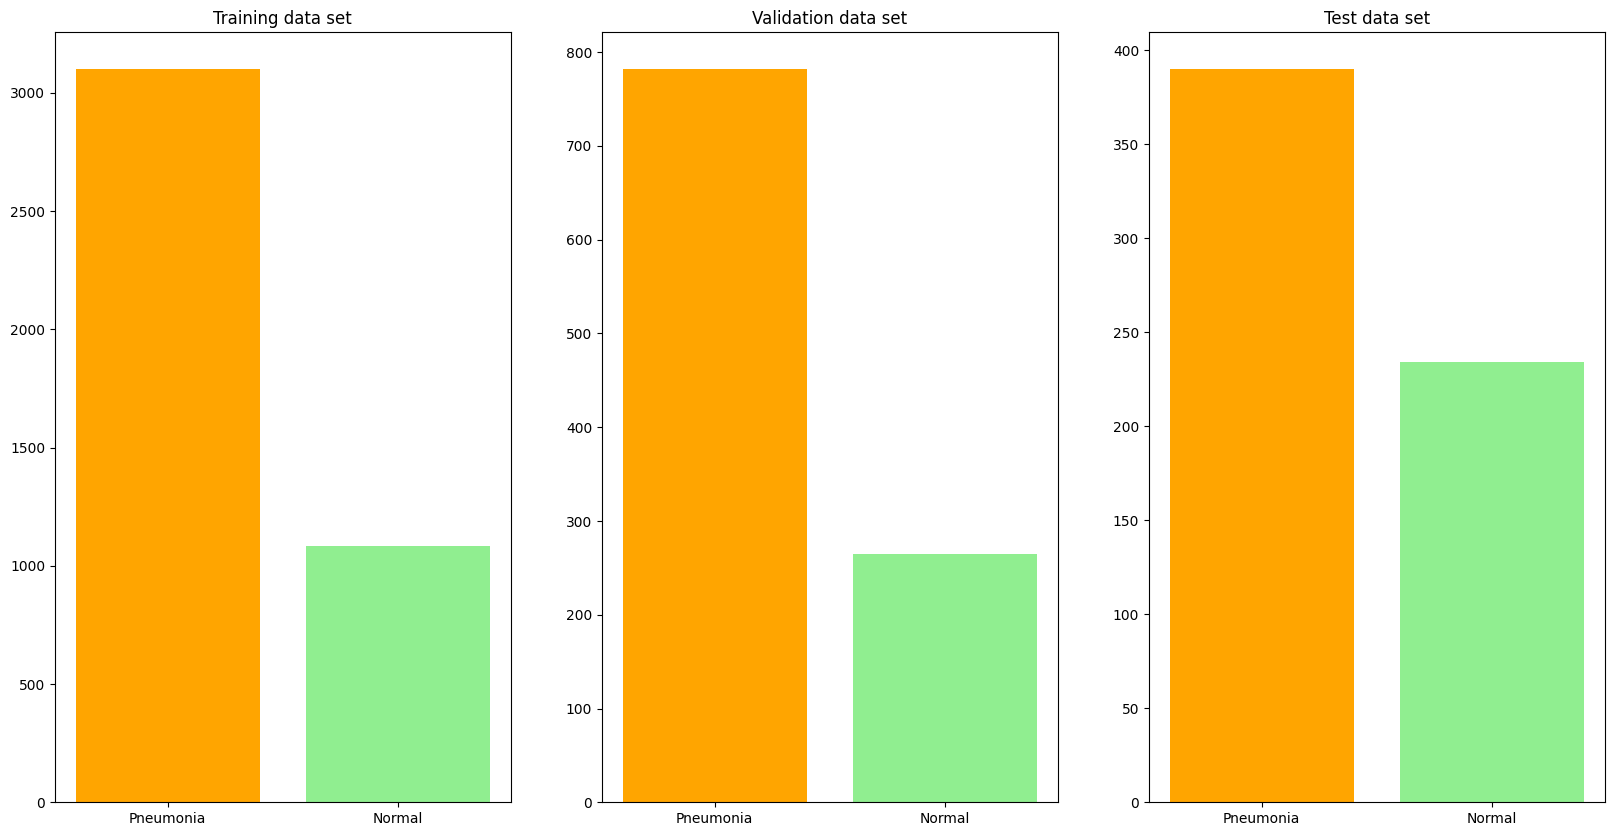

In [21]:
fig = plt.figure(figsize=(20, 10))

plt.subplot(1, 3, 1)
plt.bar(x=["Pneumonia", "Normal"], 
        height=[train_pneumonia_count, train_normal_count], 
        color=["orange", "lightgreen"])
plt.title("Training data set")

plt.subplot(1, 3, 2)
plt.bar(x=["Pneumonia", "Normal"], 
        height=[val_pneumonia_count, val_normal_count], 
        color=["orange", "lightgreen"])
plt.title("Validation data set")

plt.subplot (1 , 3 , 3)
plt.bar (x = ["Pneumonia","Normal"] ,
         height = (len (os.listdir (test_folder + "/PNEUMONIA")) , 
                    len (os.listdir (test_folder + "/NORMAL"))
                   ) , 
         color = ["orange", "lightgreen"])
plt.title ("Test data set")

plt.show()

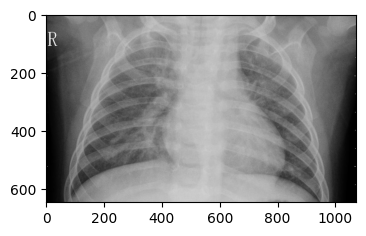

In [22]:
# 폐렴 샘플이미지 시각화
fig = plt.figure(figsize = (4,3))
plt.imshow(load_img(random.choice(pneumonia_list)))
plt.show()

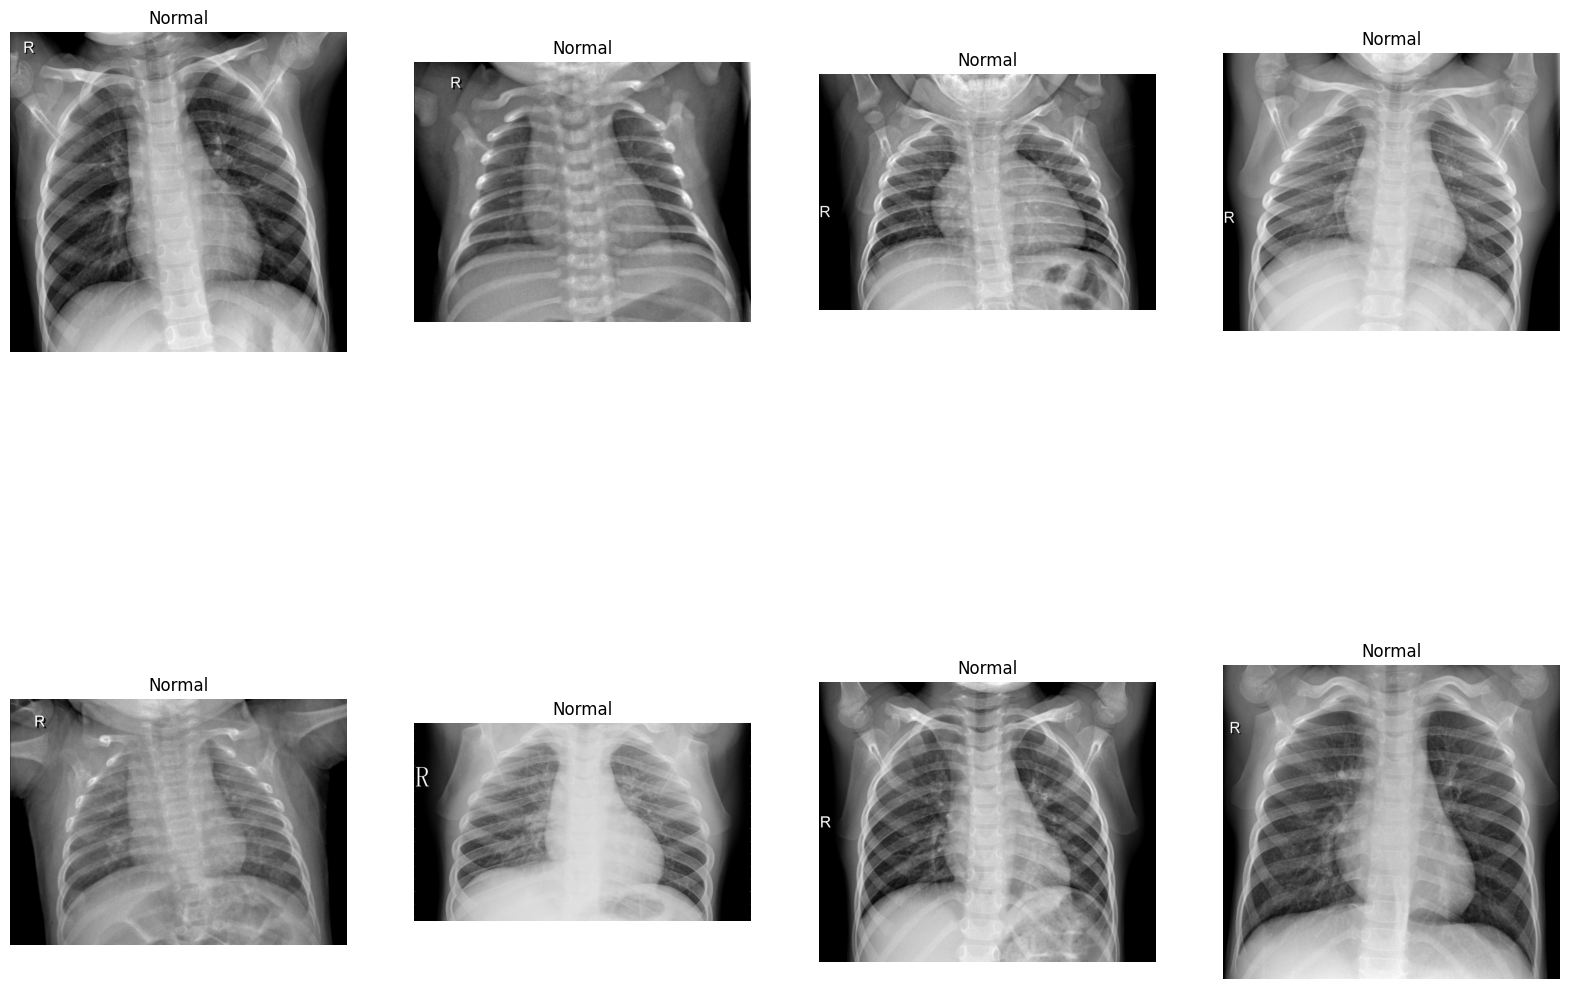

In [23]:
# 여러장의 건강한 폐 샘플이미지 시각화
fig = plt.figure(figsize = (20, 15))
columns, rows = 4, 2
for i in range(1,9):
    img = cv2.imread(random.choice(normal_list))
    fig.add_subplot(rows, columns, i)
    plt.title('Normal')
    plt.axis('off')
    plt.imshow(img)
   

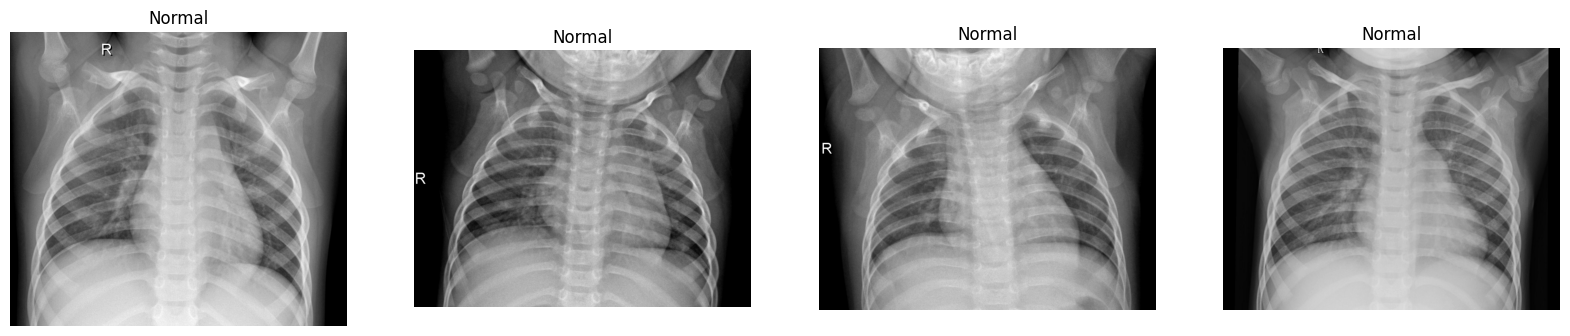

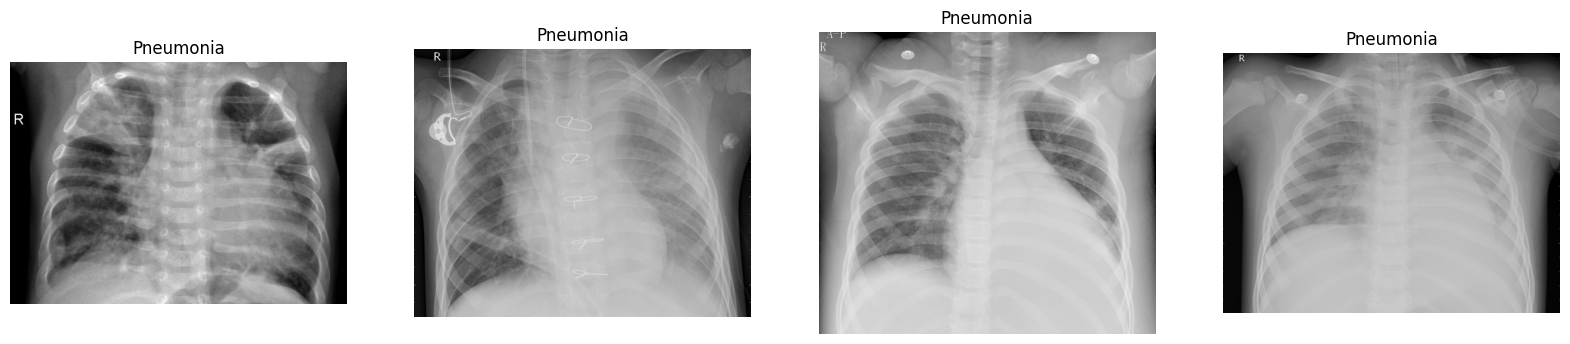

In [24]:
# 여러장의 건강한 폐 샘플이미지와 폐렴 샘플 이미지를 시각화
num_samples = 4
fig, axes = plt.subplots(nrows=1, ncols=num_samples, figsize=(20,10))
for i in range(num_samples):
    img_path = random.choice(normal_list)
    img = mpimg.imread(img_path)
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title('Normal')
    axes[i].axis('off')

fig, axes = plt.subplots(nrows=1, ncols=num_samples, figsize=(20,10))
for i in range(num_samples):
    img_path = random.choice(pneumonia_list)
    img = mpimg.imread(img_path)
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title('Pneumonia')
    axes[i].axis('off')

###  전처리 및 배치 데이터세트 생성 Data Augmentation and Batch Dataset Generation

X-ray 이미지를 환자에게서 스캔시, 환자가 항상 특정한 포지션을 취한 뒤 촬영하고, 결과물 이미지도 같으므로 데이터 이미지 증식을 따로 할 필요가 없다고 생각됩니다. 따라서, 이미지를 플립하거나, 로테이션 하는 등의 전처리는 진행하지 않는것이 처음의 플랜이었습니다. <br><br>
하지만 위의 바 그래프에서 보여지듯이, 폐렴 이미지의 숫자가 건강한 폐 이미지 보다 많습니다. 이는 데이터의 class imabalnce를 의미하므로, 모델이 편향되게 학습될 수 있음을 의미합니다.
<br>
따라서 각 클래스의 양을 비슷하게 만들기 위해서 할 수 있는 방법 중 data augmentation을 선택해, 특정한 포지션의 정상인 폐와 폐렴의 이미지만이 아닌, 변형된 이미지 데이터 양을 늘려, 모델이 편향되지 않도록 전처리를 진행하였습니다. <br>
- 이미지를 512,512로 리사이즈
- 이미지를 랜덤으로 크롭
- 50% 확률로 수평으로 플립
- 20% 확률로 밝기대비 적용
- 정규화
<br>
참고: DataGenerator는 일반적으로 전체 데이터 세트를 메모리에 맞출 수 없는 경우 Keras 모델을 학습하기 위한 데이터 일괄 처리를 생성하는 데 사용됩니다. 이미지 데이터의 양이 많으므로, DataGenerator를 사용하겠습니다. 

In [25]:
class AlbumentationsDataset(Dataset):
    def __init__(self, file_list, batch_size=32, shuffle=True, augmentation=True):
        self.file_list = file_list
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augmentation = augmentation
    
        self.aug = A.Compose([
            A.Resize(512,512), 
            A.RandomCrop(448, 448), # 
            A.HorizontalFlip(p=0.5), # 50% 확률로 플립
            A.RandomBrightnessContrast(p=0.2), # 20% 확률로 밝기 대비
            A.Normalize()            
        ])
        
        if self.shuffle:
            np.random.shuffle(self.file_list)
    
    
    def __len__(self):
        return int(np.ceil( len(self.file_list) / float(self.batch_size) ) )


    def __getitem__(self, idx):
        
        batch_files = self.file_list[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        batch_images = []
        batch_labels = []
        
        for file in batch_files:
            img = cv2.imread(file)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            if "PNEUMONIA" in file:
                label = 1
            else:
                label = 0
            
            if self.augmentation:
                img = self.aug(image=img)['image'] # 인풋이미지 img를 self.aug 파이프라인에 적용
                # augmented 된 이미지 image를 다시 img에 set
            batch_images.append(img)
            batch_labels.append(label)
        
        batch_images = np.array(batch_images)
        batch_labels = np.array(batch_labels)

        return batch_images, batch_labels

In [26]:
class DataGenerator(Sequence):
    def __init__(self, dataset, batch_size=32, shuffle=True):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        batch_x, batch_y = self.dataset[idx]

        return batch_x, batch_y

In [27]:
train_aug = AlbumentationsDataset(file_list=train_files, batch_size=32, shuffle=True, augmentation=True)
val_aug = AlbumentationsDataset(file_list=val_files, batch_size=16, shuffle=True, augmentation=True)

train_gen = DataGenerator(train_aug, batch_size=32)
val_gen = DataGenerator(val_aug, batch_size=16)

In [28]:
test_aug = AlbumentationsDataset(file_list=test_list, batch_size=12, shuffle=True, augmentation=True)
test_gen = DataGenerator(test_aug, batch_size=12)

In [29]:
def plot_images(images):
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10,5))
    axes = axes.ravel()
    for i in np.arange(0, len(images)):
        axes[i].imshow(images[i], cmap='gray')
        axes[i].axis('off')
    plt.subplots_adjust(wspace=0.5)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


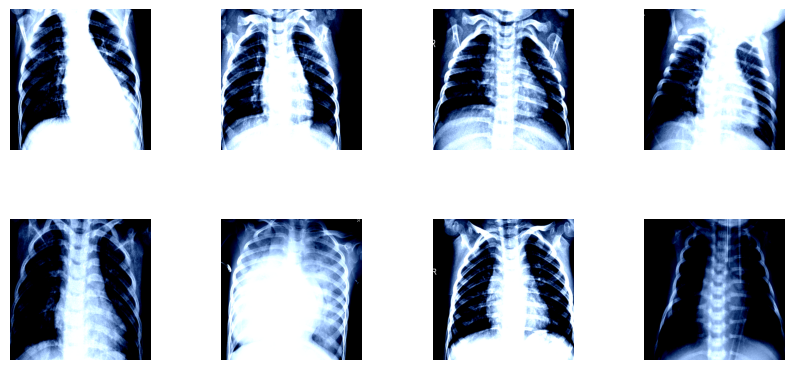

In [30]:
# 8개의 학습train 배치 이미지를 시각화 
x, y = train_gen.__getitem__(0)
plot_images(x[:8])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


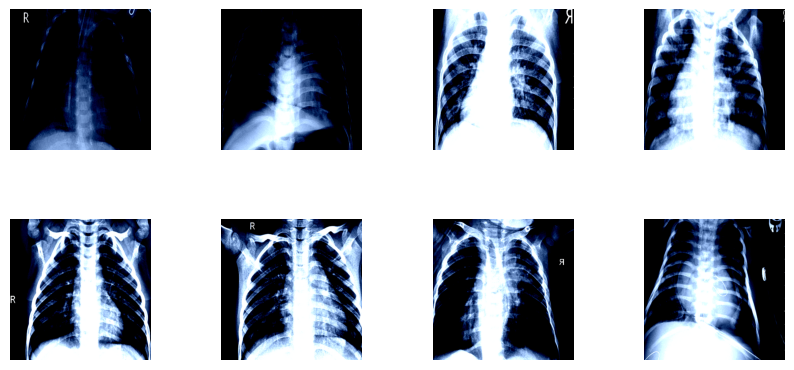

In [31]:
# 8개의 벨리데이션 배치 이미지를 시각화 
x_val, y_val = val_gen.__getitem__(0)
plot_images(x_val[:8])

### 모델 빌드 Build a model 

모델 빌드 전 고려할 사항
- 데이터가 한정적일때 딥러닝 모델 아키텍쳐를 어떻게 할 것인가 -> 심플하게 simple 
- Pretrain-model을 가져와서 transfer learning을 할때 전체를 가져올것인가 부분적으로 가져올것인가 -> 부분적으로 partially 
    - pre-trained 모델이 대규모 데이터셋에서 학습된 가중치를 사용하므로, 초기화된 가중치보다 더 좋은 초기값을 가지고 있기 때문에, Pretrain모델의 일부 레이어들의 가중치를 fine-tuning 미세조정합니다 
    - 일반적인 pre-trained모델을 살펴보면 (CNN을 예시로), 모델의 상위 레이어들은 이미지의 high-level feature(e.g. contour of object, feature)를 캡쳐하고 하위 레이어들은 low-level feature(e.g. line선 가장자리edge등의 texture feature)을 학습했습니다.
    - 때문에, 하위 레이어들에 대해서는 가중치를 동결freeze하고, 상위 레이어들을 task-specific한 feature 특징들을 학습하도록 미세조정 fine-tuning 하는것이 좋습니다. (참고로, 상위 레이어들의 high-level feature가 이미지 분류 및 객체 감지 task에서 중요합니다) 
    <br>
    - task 목표가 폐렴을 감지하는 것으로, 상위 레이어들 미세 조정 fine tuning 하여 램던하게 초기화된 가중치보다 좋은 결과를 
    - 일반적으로 fine-tuning시 Pre-trained 된 모델들의 레이어 가중치를 미세 조정하면, 랜덤하게 초기화된 가중치보다 훨씬 좋은 결과를 얻을 수 있습니다.

#### 전이모델 Pretrained VGG16

In [ ]:
# ImageNet으로 pre-trained된 VGG16 모델 불러오기
pretrained_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 모델 미세 조정을 위해 전이모델 레이어 고정 froze
for layer in pretrained_vgg16.layers:
    layer.trainable = False


# 맞는 레이어를 froze했는지 한번 더 확인
for i, layer in enumerate(pretrained_vgg16.layers):
    print(i, layer.name, layer.trainable)

pretrained_vgg16.summary()   

In [ ]:
top_model = pretrained_vgg16.output
top_model = GlobalAveragePooling2D()(top_model)
top_model = Dense(256, activation='relu')(top_model)
top_model = Dropout(0.5)(top_model) # overfitting을 줄이기 위한 드롭아웃 레이어
top_model = Dense(128, activation='relu')(top_model)
top_model = Dropout(0.2)(top_model)
prediction = Dense(1, activation='sigmoid')(top_model)

vgg_model2 = Model(inputs=pretrained_vgg16.input, outputs = prediction)
vgg_model2.summary()

#### 콜백 설정
Pedro Marcelino가 설명한 바에 따르면, 높은 학습률 high learning rate는 이전의 지식을 잃을 위험을 증가시키기 때문에, 낮은 학습률을 설정하는 것이 좋다고 합니다. <br>
모델의 개선이 없다면, learning rate를 조절해 모델의 개선을 유도하는 콜백 함수인 ReduceLROnPlateau을 사용하면 모델을 미세조정하는데 유용합니다. 

- early stopping 을 통해 지표가 개선 안되는 학습과정에서 불필요한 연산 시간을 절약할 수 있으며, 최적의 모델을 얻을 수 있습니다.
- early stopping의 지표로 벨리데이션 정확도를 지정하고 ``monitor=validation_loss``, mode는 최대로 두었습니다. ``mode=max``. 
- patience를 5로하여 5epoch동안 지표가 개선 안되면 학습을 중단하도록 설정하였습니다

In [28]:
# early stopping의 지표로 벨리데이션 정확도를 선택 
early_stop = EarlyStopping(monitor='val_loss', 
                           patience=5, # epoch 5 동안 개선되지 않으면 callback이 호출됩니다
                           mode='min', 
                           restore_best_weights=True)


reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', 
                                   factor=0.8, # 새로운 learning rate는 기존 learning rate * factor
                                   patience=10, # epoch 10 동안 개선되지 않으면 callback이 호출됩니다
                                   verbose=1, # 1일경우 EarlyStopping이 적용될때 적용되었다고 나타냅니다. 
                                   mode='auto', # monitor되는 값이 최소가 되어야 하는지, 최대가 되어야 하는지 알려주는 인자
                                   epsilon=0.0001, # 개선된 것으로 간주하기 위한 최소한의 변화량
                                   min_lr=5e-5)

# ModelCheckpoint 콜백(callback) 정의
checkpoint_callback = ModelCheckpoint(
    # 학습중 벨리데이션 정확도가 증가시, 파일경로에 모델의 가중치를 저장
    filepath="saved_model/xray_vgg16_model2.h5" ,
    # 모니터 부분에 지표로 벨리데이션 정확도를 명시, 모드 부분은 지표를 최대 지정하여 최고의 정확도인지를 모니터링 
    monitor='val_accuracy',
    mode='max',
    # 최고버전의 모델을 보장
    save_best_only=True
)

In [ ]:
# 모델 컴파일
opt1 = Adam(lr=1e-5) # 00001
opt2 = Adam(lr=5e-5) # 00005
vgg_model2.compile(loss='binary_crossentropy',
                   optimizer=opt2,
                   metrics=['accuracy'])



# 모델 학습 전 현재 시간 기록
start_time = time.time()

# 모델 학습
vgg_history = vgg_model2.fit(train_gen,
                             epochs=20,
                             validation_data=val_gen,
                             callbacks=[early_stop, reduceLROnPlat, checkpoint_callback])
# 걸린 시간 계산
elapsed_time = time.time() - start_time
# 시간 출력
print(f"Elapsed Time: {datetime.timedelta(seconds=elapsed_time)}")

In [40]:
vgg_model2.save('saved_model/xray_vgg16_model2.h5')
vgg_model2 = load_model('saved_model/xray_vgg16_model2.h5')

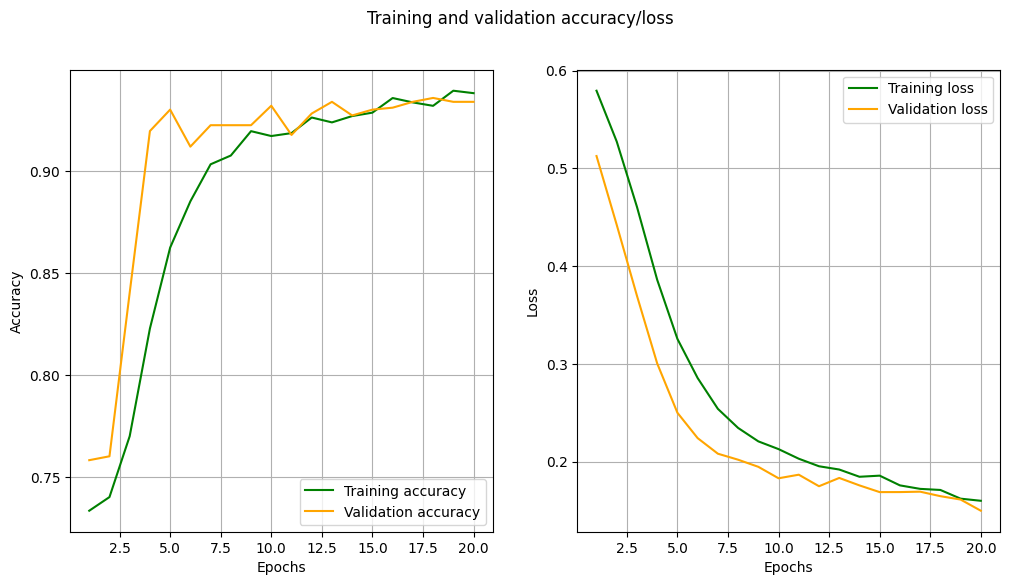

In [50]:
vgg_train_loss = vgg_history.history['loss']
vgg_val_loss = vgg_history.history['val_loss']
vgg_train_acc = vgg_history.history['accuracy']
vgg_val_acc = vgg_history.history['val_accuracy']
epochs = range(1, len(vgg_train_acc) + 1)

# 두 개의 서브플롯을 가진 하나의 피규어
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# 정확도를 왼쪽 서브플롯에 플롯
ax1.plot(epochs, vgg_train_acc, 'green', label='Training accuracy')
ax1.plot(epochs, vgg_val_acc, 'orange', label='Validation accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# 손실을 오른쪽 서브플롯에 플롯
ax2.plot(epochs, vgg_train_loss, color='green', label='Training loss')
ax2.plot(epochs, vgg_val_loss, color='orange', label='Validation loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

plt.suptitle('Training and validation accuracy/loss')
plt.show()

In [51]:
# VGG16 모델 평가
vgg_test_loss, vgg_test_accu = vgg_model2.evaluate_generator(test_gen)
print("Test loss is: {}, Test Accuracy is: {}".format(vgg_test_loss, vgg_test_acccuracy))

Test loss is: 0.5830598473548889, Test Accuracy is: 0.7724359035491943


#### 전이모델 Pretrained Resnet50
- 베이스 모델로 pretrained resnet50을 넣어주고, input 사이즈를 224,224,3로 지정하였습니다. 
- 때문에 data augmentation에서 Resize부분을 A.Resize(256,256)로 바꿔주고, 이미지를 랜덤으로 크롭하는 부분을 A.RandomCrop(224, 224)로 바꾸어 준 뒤에 모델 학습을 진행했습니다

In [ ]:
# ImageNet으로 pre-trained된 ResNet50 모델 로드
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224, 3))

# 모델 구조 출력
resnet_base.summary()

# 기본 모델 동결 
resnet_base.trainable = False

In [ ]:
top_model = resnet_base.output
top_model = GlobalAveragePooling2D()(top_model)
top_model = Dense(256, activation='relu')(top_model)
top_model = Dropout(0.5)(top_model)
top_model = Dense(128, activation='relu')(top_model)
top_model = Dropout(0.5)(top_model)
prediction = Dense(1, activation='sigmoid')(top_model)
# 새로운 모델 생성
resnet_model1 = Model(inputs=resnet_base.input, outputs=prediction)

# 새로운 모델 구조 출력
resnet_model1.summary()

In [65]:
# 모델 컴파일, fine-tuning 시 optimizer, loss function, metric 등 설정
resnet_model1.compile(optimizer=opt1, 
                      loss='binary_crossentropy', 
                      metrics=['accuracy'])

# ModelCheckpoint 콜백(callback) 정의
checkpoint_filepath = 'saved_model/xray_res50_model1.h5' 
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath,
                                      monitor='val_accuracy',
                                      mode='max',
                                      save_best_only=True)


# 모델 학습 전 현재 시간 기록
start_time = time.time()

# 모델 학습
res_history = resnet_model1.fit(train_gen,
                                epochs=20,
                                validation_data=val_gen,
                                callbacks=[early_stop, reduceLROnPlat, checkpoint_callback])


# 모델 학습 후 현재 시간 기록
end_time = time.time()

# 걸린 시간 계산
elapsed_time = end_time - start_time

# 시간 출력
print(f"Elapsed Time: {datetime.timedelta(seconds=elapsed_time)}")

Epoch 1/20
131/131 [==============================] - 347s 3s/step - loss: 0.8301 - accuracy: 0.6860 - val_loss: 0.4361 - val_accuracy: 0.7593 - lr: 1.0000e-05
Epoch 2/20
131/131 [==============================] - 293s 2s/step - loss: 0.6612 - accuracy: 0.6898 - val_loss: 0.3751 - val_accuracy: 0.7966 - lr: 1.0000e-05
Epoch 3/20
131/131 [==============================] - 293s 2s/step - loss: 0.5703 - accuracy: 0.7240 - val_loss: 0.3479 - val_accuracy: 0.8376 - lr: 1.0000e-05
Epoch 4/20
131/131 [==============================] - 293s 2s/step - loss: 0.5027 - accuracy: 0.7529 - val_loss: 0.3356 - val_accuracy: 0.8500 - lr: 1.0000e-05
Epoch 5/20
131/131 [==============================] - 293s 2s/step - loss: 0.4602 - accuracy: 0.7783 - val_loss: 0.3203 - val_accuracy: 0.8520 - lr: 1.0000e-05
Epoch 6/20
131/131 [==============================] - 293s 2s/step - loss: 0.4280 - accuracy: 0.7967 - val_loss: 0.3163 - val_accuracy: 0.8558 - lr: 1.0000e-05
Epoch 7/20
131/131 [====================

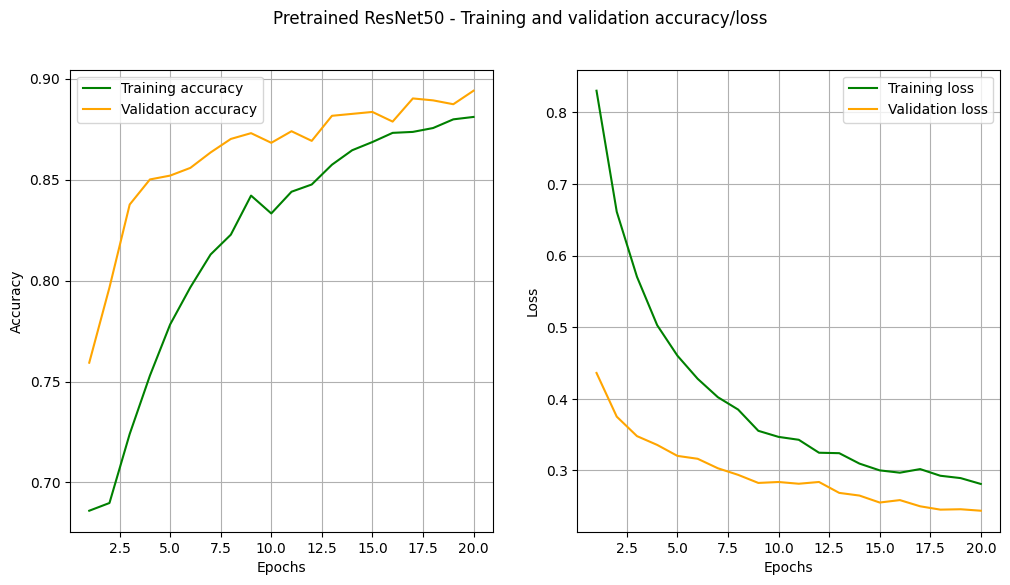

In [68]:
res_train_loss = res_history.history['loss']
res_val_loss = res_history.history['val_loss']
res_train_acc = res_history.history['accuracy']
res_val_acc = res_history.history['val_accuracy']
epochs = range(1, len(res_train_acc) + 1)

# 두 개의 서브플롯을 가진 하나의 피규어
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# 정확도를 왼쪽 서브플롯에 플롯
ax1.plot(epochs, res_train_acc, 'green', label='Training accuracy')
ax1.plot(epochs, res_val_acc, 'orange', label='Validation accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# 손실을 오른쪽 서브플롯에 플롯
ax2.plot(epochs, res_train_loss, color='green', label='Training loss')
ax2.plot(epochs, res_val_loss, color='orange', label='Validation loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

plt.suptitle('Pretrained ResNet50 - Training and validation accuracy/loss')
plt.show()

In [69]:
# resnet50 모델 평가1
res_test_loss, res_test_accu = resnet_model1.evaluate_generator(test_gen)
print("Test loss is: {}, Test Accuracy is: {}".format(res_test_loss, res_test_accu))

resnet_model1.save(checkpoint_filepath)

Test loss is: 0.4932659864425659, Test Accuracy is: 0.7612179517745972


#### 전이모델 Pretrained EfficientNetB0

In [35]:
# ImageNet으로 pre-trained된 InceptionV3 모델 로드
inc_base = InceptionV3(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))

# 모델 구조 출력
inc_base.summary()

# 기본 모델 레이어 동결 
for layer in inc_base.layers:   
    layer.trainable = False

# 레이어 추가 
top_model = inc_base.output
top_model = GlobalAveragePooling2D()(top_model)
top_model = BatchNormalization()(top_model)
top_model = Dense(256, activation='relu')(top_model)
top_model = Dropout(0.5)(top_model)
top_model = BatchNormalization()(top_model)
top_model = Dense(128, activation='relu')(top_model)
top_model = Dropout(0.5)(top_model)
prediction = Dense(1, activation='sigmoid')(top_model)
# 새로운 모델 생성
inc_model1 = Model(inputs=inc_base.input, outputs=prediction)

# 새로운 모델 구조 출력
inc_model1 .summary()

87924736/87910968 [==============================] - 2s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)           

In [38]:
opt1 = Adam(lr=1e-5) # 00001
opt2 = Adam(lr=5e-5) # 00005

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', 
                                   factor=0.8, # 새로운 learning rate는 기존 learning rate * factor
                                   patience=10, # epoch 10 동안 개선되지 않으면 callback이 호출됩니다
                                   verbose=1, # 1일경우 EarlyStopping이 적용될때 적용되었다고 나타냅니다. 
                                   mode='auto', # monitor되는 값이 최소가 되어야 하는지, 최대가 되어야 하는지 알려주는 인자
                                   epsilon=0.0001, # 개선된 것으로 간주하기 위한 최소한의 변화량
                                   min_lr=5e-5)

# early stopping의 지표로 벨리데이션 정확도를 선택 
early_stop = EarlyStopping(monitor='val_loss', 
                           patience=5,
                           mode='auto', # InceptionV3에서는 min에서 auto로 변경
                           restore_best_weights=True)

In [39]:


# 모델 컴파일, fine-tuning 시 optimizer, loss function, metric 등 설정
inc_model1.compile(optimizer=opt1, 
                   loss='binary_crossentropy', 
                   metrics=['accuracy'])

# ModelCheckpoint 콜백(callback) 정의
checkpoint_filepath = 'saved_model/xray_inception_model1.h5' 
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath,
                                      monitor='val_accuracy',
                                      mode='max',
                                      save_best_only=True)

# 모델 학습 전 현재 시간 기록
start_time = time.time()

# 모델 학습
inc_history = inc_model1.fit(train_gen,
                             epochs=20,
                             validation_data=val_gen,
                             callbacks=[early_stop, reduceLROnPlat, checkpoint_callback])


# 모델 학습 후 현재 시간 기록
end_time = time.time()

# 걸린 시간 계산
elapsed_time = end_time - start_time

# 시간 출력
print(f"Elapsed Time: {datetime.timedelta(seconds=elapsed_time)}")

Epoch 1/20
131/131 [==============================] - 176s 1s/step - loss: 0.8896 - accuracy: 0.5281 - val_loss: 0.7134 - val_accuracy: 0.4585 - lr: 1.0000e-05
Epoch 2/20
131/131 [==============================] - 129s 981ms/step - loss: 0.7358 - accuracy: 0.6131 - val_loss: 0.6012 - val_accuracy: 0.6953 - lr: 1.0000e-05
Epoch 3/20
131/131 [==============================] - 129s 982ms/step - loss: 0.6381 - accuracy: 0.6734 - val_loss: 0.4911 - val_accuracy: 0.7994 - lr: 1.0000e-05
Epoch 4/20
131/131 [==============================] - 129s 981ms/step - loss: 0.5992 - accuracy: 0.7097 - val_loss: 0.4145 - val_accuracy: 0.8434 - lr: 1.0000e-05
Epoch 5/20
131/131 [==============================] - 129s 983ms/step - loss: 0.5246 - accuracy: 0.7481 - val_loss: 0.3514 - val_accuracy: 0.8797 - lr: 1.0000e-05
Epoch 6/20
131/131 [==============================] - 129s 980ms/step - loss: 0.5066 - accuracy: 0.7584 - val_loss: 0.3360 - val_accuracy: 0.8749 - lr: 1.0000e-05
Epoch 7/20
131/131 [=====

In [40]:
# InceptionV3 모델 평가1
inc_test_loss, inc_test_accu = inc_model1.evaluate_generator(test_gen)
print("Test loss is: {}, Test Accuracy is: {}".format(inc_test_loss, inc_test_accu))

inc_model1.save(checkpoint_filepath)

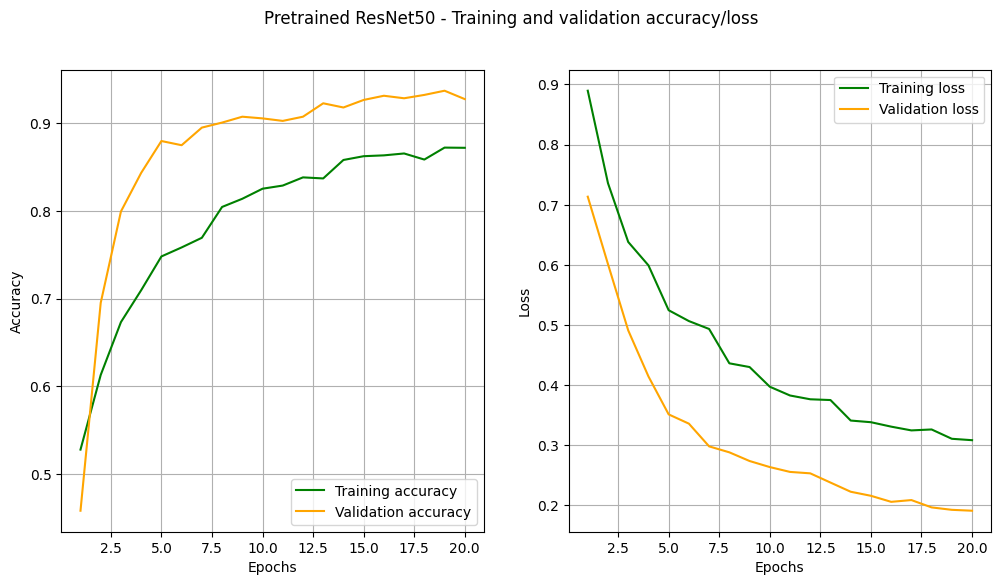

In [42]:
inc_train_loss = inc_history.history['loss']
inc_val_loss = inc_history.history['val_loss']
inc_train_acc = inc_history.history['accuracy']
inc_val_acc = inc_history.history['val_accuracy']
epochs = range(1, len(inc_train_acc) + 1)

# 두 개의 서브플롯을 가진 하나의 피규어
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# 정확도를 왼쪽 서브플롯에 플롯
ax1.plot(epochs, inc_train_acc, 'green', label='Training accuracy')
ax1.plot(epochs, inc_val_acc, 'orange', label='Validation accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# 손실을 오른쪽 서브플롯에 플롯
ax2.plot(epochs, inc_train_loss, color='green', label='Training loss')
ax2.plot(epochs, inc_val_loss, color='orange', label='Validation loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

plt.suptitle('Pretrained ResNet50 - Training and validation accuracy/loss')
plt.show()

#### 전이모델 Pretrained InceptionV3

#### 전이모델 Pretrained Xception

### 레퍼런스 
1. https://www.kaggle.com/code/mohitkeshwanii/pneumonia-detection-ensemble-vgg16-mobilenetv2#Helper-Functions
2. 
3. https://towardsdatascience.com/cifar-100-transfer-learning-using-efficientnet-ed3ed7b89af2
4. https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/
5. https://keep-steady.tistory.com/35

https://zeuskwon-ds.tistory.com/49